In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sns
from scipy.stats import uniform, normaltest
from sklearn import svm, neighbors, tree
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.preprocessing import normalize, PowerTransformer, OneHotEncoder, OrdinalEncoder, Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import rand_score,adjusted_mutual_info_score

In [3]:
data_sim = pd.read_csv('data.txt',index_col=0)

# Adding Noise
np.random.seed(1)
for col in data_sim:
    if col != 'Contains_Crack' and col != 'Position_of_Crack':
        std_TR = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Top Right', col])
        std_TL = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Top Left', col])
        std_BL = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Bottom Left', col])
        std_BR = np.std(data_sim.loc[data_sim['Position_of_Crack'] == 'Bottom Right', col])
        std_avg = (std_TR+std_TL+std_BL+std_BR)/4
    
        noise = np.random.uniform(-std_avg,std_avg,len(data_sim[col]))
        data_sim[col] = data_sim[col] + noise

y1_sim2 = data_sim.Contains_Crack
y2_sim2 = data_sim.Position_of_Crack
        
# Remove Sim targets
data_sim.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1_sim = data_sim.Contains_Crack
y2_sim = data_sim.Position_of_Crack
data_sim.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)

# Encoding targets
for idx in range(len(y1_sim)):
    if y1_sim[idx] == 'Yes':
        y1_sim[idx] = int(1)
    elif y1_sim[idx] == 'No': 
        y1_sim[idx] = int(0)
    
    if y2_sim[idx] == 'No Crack':
        y2_sim[idx] = int(0)
    elif y2_sim[idx] == 'Top Right':
        y2_sim[idx] = int(1)
    elif y2_sim[idx] == 'Top Left':
        y2_sim[idx] = int(2)
    elif y2_sim[idx] == 'Bottom Left':
        y2_sim[idx] = int(3)
    elif y2_sim[idx] == 'Bottom Right':
        y2_sim[idx] = int(4)      
        
y1_sim = y1_sim.to_numpy(dtype=int)
y2_sim = y2_sim.to_numpy(dtype=int)

# Split the sim data into feature sets
X1_sim = data_sim
X2_sim = data_sim[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data_sim[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data_sim[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data_sim[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data_sim[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data_sim[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3_sim = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

data_sim.head(7)

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,nf2,nf2_amp1,nf2_amp2,nf2_amp3,...,nf8_amp2,nf8_amp3,nf8_amp4,nf8_amp5,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,163.516307,1.038170,1.068703,0.021232,1.062176,0.830729,239.927829,0.024641,0.063642,-0.083850,...,0.115399,2.172240,-0.029574,0.416695,838.715944,0.142866,0.098044,0.036677,0.128474,0.030246
1,161.841610,1.044121,1.041205,0.119850,1.043862,0.951773,229.215934,0.033343,0.079914,0.645732,...,0.078016,2.183178,0.011719,0.074832,822.922837,0.565163,0.135012,0.129534,0.459730,0.288985
2,162.592673,1.158212,1.049316,0.068532,0.994574,0.935274,233.397982,0.162332,0.049100,-0.045416,...,0.253353,2.012175,0.230414,0.993327,825.845806,0.053755,0.275476,0.058117,0.141599,0.425193
3,161.440661,1.038107,1.053830,0.049393,1.064906,0.878473,231.460462,0.067496,0.064221,0.418760,...,0.283376,2.249152,0.412205,0.482657,838.426601,0.120835,0.173844,-0.024460,0.083506,0.037301
4,161.962008,1.052786,1.024647,-0.007485,1.041829,1.119997,236.767770,0.043564,0.044070,0.056621,...,-0.051874,2.148435,0.198727,0.079879,835.374843,0.085093,-0.047885,0.068026,0.031878,0.102733
5,162.523635,1.047351,1.042740,-0.002253,1.061694,0.998956,241.820360,0.042069,0.065227,-0.040708,...,-0.074979,2.166130,0.021629,0.282718,843.228906,0.188047,0.081965,0.021252,-0.063861,0.012698
6,158.612786,1.032064,1.032980,0.072829,1.031189,1.217503,235.209321,0.063937,0.082172,0.398792,...,-0.087697,2.068172,-0.098057,0.617637,839.125209,0.191396,0.059224,0.136539,0.018024,0.137466


In [4]:
# Read Exp data
pd.set_option('display.max_columns', 12)
data_exp = pd.read_csv('experiment_data.txt',index_col=0)

y1_exp2 = data_exp.Contains_Crack
y2_exp2 = data_exp.Position_of_Crack

# Remove Exp targets
data_exp.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1_exp = data_exp.Contains_Crack
y2_exp = data_exp.Position_of_Crack
data_exp.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)
    
# Split the Exp data into feature sets
X1_exp = data_exp
X2_exp = data_exp[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data_exp[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data_exp[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data_exp[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data_exp[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data_exp[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3_exp = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

# Encoding targets
for idx in range(len(y1_exp)):
    if y1_exp[idx] == 'Yes':
        y1_exp[idx] = int(1)
    elif y1_exp[idx] == 'No': 
        y1_exp[idx] = int(0)
    
    if y2_exp[idx] == 'No Crack':
        y2_exp[idx] = int(0)
    elif y2_exp[idx] == 'Top Right':
        y2_exp[idx] = int(1)
    elif y2_exp[idx] == 'Top Left':
        y2_exp[idx] = int(2)
    elif y2_exp[idx] == 'Bottom Left':
        y2_exp[idx] = int(3)
    elif y2_exp[idx] == 'Bottom Right':
        y2_exp[idx] = int(4)
        
y1_exp = y1_exp.to_numpy(dtype=int)
y2_exp = y2_exp.to_numpy(dtype=int)

data_exp.head(7)

C:\Users\James\AppData\Local\Temp/ipykernel_15132/110934160.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y1_exp[idx] = int(0)
C:\Users\James\AppData\Local\Temp/ipykernel_15132/110934160.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y2_exp[idx] = int(0)
C:\Users\James\AppData\Local\Temp/ipykernel_15132/110934160.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y1_exp[idx] = int(1)
C:\Users\James\AppData\Local\Temp/ipy

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,170.0,15.58,1.14,0.358,4.930,3.49,...,900.0,92.1,58.9,7.67,41.1,46.3
1,170.0,14.90,14.10,0.615,5.090,14.80,...,880.0,155.0,166.0,17.40,18.4,162.0
2,165.0,4.56,3.95,0.709,7.255,4.04,...,915.0,52.1,39.6,5.02,92.1,40.8
3,157.5,4.87,7.75,0.519,3.370,4.23,...,877.5,47.2,76.1,6.36,14.2,18.8
4,162.5,7.34,0.82,0.433,9.540,3.12,...,910.0,166.0,76.0,7.52,182.0,82.5
5,160.0,1.88,13.46,0.625,4.200,6.01,...,897.5,32.1,238.0,13.40,46.1,92.5
6,160.0,4.78,1.64,0.432,5.980,3.44,...,892.5,19.6,57.6,6.64,18.0,70.6


In [5]:
# Test
for col in X1_sim:
    X1_exp[col] = X1_exp[col]*((X1_sim[col].max())/(X1_exp[col].max()))

for col in X2_sim:
    X2_exp[col] = X2_exp[col]*((X2_sim[col].max())/(X2_exp[col].max()))
    
for col in X3_sim:
    X3_exp[col] = X3_exp[col]*((X3_sim[col].max())/(X3_exp[col].max()))
    
X1_exp

C:\Users\James\AppData\Local\Temp/ipykernel_15132/648763488.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2_exp[col] = X2_exp[col]*((X2_sim[col].max())/(X2_exp[col].max()))


,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,166.016930,1.158212,0.097970,0.060347,0.632636,0.836258,...,830.512081,0.416982,0.136930,0.164875,0.145548,0.168359
1,166.016930,1.107661,1.211737,0.103668,0.653168,3.546310,...,812.056257,0.701762,0.385916,0.374032,0.065160,0.589074
2,161.134080,0.338989,0.339458,0.119513,0.930989,0.968047,...,844.353949,0.235882,0.092062,0.107910,0.326155,0.148359
3,153.809803,0.362034,0.666026,0.087486,0.432451,1.013574,...,809.749279,0.213698,0.176917,0.136715,0.050287,0.068362
4,158.692654,0.545653,0.070470,0.072989,1.224209,0.747601,...,839.739993,0.751564,0.176684,0.161650,0.644518,0.299992
5,156.251229,0.139759,1.156736,0.105354,0.538960,1.440089,...,828.205103,0.145333,0.553301,0.288047,0.163254,0.336354
6,156.251229,0.355344,0.140940,0.072820,0.767376,0.824278,...,823.591147,0.088739,0.133908,0.142734,0.063744,0.256720
7,161.134080,0.352370,0.028188,0.070629,0.999642,0.920124,...,835.126037,0.337298,0.060677,0.128117,0.351652,0.126542
8,158.692654,0.328581,0.116877,0.119850,0.639052,2.611810,...,835.126037,0.073345,0.151576,0.238606,0.410792,0.716344


In [6]:
X1_sim

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,163.516307,1.038170,1.068703,0.021232,1.062176,0.830729,...,838.715944,0.142866,0.098044,0.036677,0.128474,0.030246
1,161.841610,1.044121,1.041205,0.119850,1.043862,0.951773,...,822.922837,0.565163,0.135012,0.129534,0.459730,0.288985
2,162.592673,1.158212,1.049316,0.068532,0.994574,0.935274,...,825.845806,0.053755,0.275476,0.058117,0.141599,0.425193
3,161.440661,1.038107,1.053830,0.049393,1.064906,0.878473,...,838.426601,0.120835,0.173844,-0.024460,0.083506,0.037301
4,161.962008,1.052786,1.024647,-0.007485,1.041829,1.119997,...,835.374843,0.085093,-0.047885,0.068026,0.031878,0.102733
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,162.965998,1.056900,1.019373,0.023410,1.061058,0.888231,...,843.224625,-0.005461,-0.050806,0.051564,0.064393,-0.022629
96,160.879274,1.022117,1.119511,0.082316,1.057186,0.832265,...,827.146286,0.127383,0.116638,0.248995,0.304281,0.077025
97,162.440264,1.028118,1.011183,0.019398,1.055071,0.977400,...,828.464281,0.000394,0.245330,0.056035,0.243257,0.208921
98,163.178099,1.018555,1.058280,0.050581,1.157652,0.794373,...,835.827020,0.500143,0.284131,0.042238,0.096635,0.045737


In [7]:
# Mean Center the data
for col in X1_sim:
    X1_exp[col] = X1_exp[col] - X1_sim[col].mean()
    X1_sim[col] = X1_sim[col] - X1_sim[col].mean()

for col in X2_sim:
    X2_exp[col] = X2_exp[col] - X2_sim[col].mean()
    X2_sim[col] = X2_sim[col] - X2_sim[col].mean()
    
for col in X3_sim:
    X3_exp[col] = X3_exp[col] - X3_sim[col].mean()
    X3_sim[col] = X3_sim[col] - X3_sim[col].mean()

C:\Users\James\AppData\Local\Temp/ipykernel_15132/1880744424.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2_exp[col] = X2_exp[col] - X2_sim[col].mean()
C:\Users\James\AppData\Local\Temp/ipykernel_15132/1880744424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2_sim[col] = X2_sim[col] - X2_sim[col].mean()


In [8]:
X1_sim

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,1.162363,-0.006972,0.016339,-0.013802,0.014803,-0.316782,...,4.706269,-0.019932,-0.030164,-0.043621,-0.023595,-0.121468
1,-0.512334,-0.001021,-0.011159,0.084816,-0.003511,-0.195739,...,-11.086838,0.402364,0.006804,0.049236,0.307661,0.137271
2,0.238729,0.113070,-0.003048,0.033497,-0.052800,-0.212238,...,-8.163870,-0.109044,0.147268,-0.022181,-0.010470,0.273479
3,-0.913283,-0.007036,0.001466,0.014358,0.017532,-0.269038,...,4.416925,-0.041963,0.045636,-0.104757,-0.068563,-0.114413
4,-0.391936,0.007643,-0.027717,-0.042520,-0.005545,-0.027514,...,1.365167,-0.077706,-0.176092,-0.012272,-0.120191,-0.048981
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.612055,0.011757,-0.032991,-0.011625,0.013685,-0.259281,...,9.214949,-0.168260,-0.179014,-0.028734,-0.087676,-0.174343
96,-1.474670,-0.023026,0.067147,0.047281,0.009813,-0.315247,...,-6.863389,-0.035416,-0.011570,0.168697,0.152212,-0.074689
97,0.086320,-0.017025,-0.041182,-0.015637,0.007698,-0.170112,...,-5.545395,-0.162404,0.117123,-0.024263,0.091189,0.057207
98,0.824155,-0.026587,0.005916,0.015547,0.110279,-0.353139,...,1.817344,0.337344,0.155924,-0.038060,-0.055434,-0.105977


In [9]:
X1_exp

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,3.662987,0.113070,-0.954394,0.025312,-0.414737,-0.311253,...,-3.497595,0.254184,0.008723,0.084577,-0.006521,0.016645
1,3.662987,0.062519,0.159373,0.068633,-0.394205,2.398798,...,-21.953419,0.538963,0.257708,0.293734,-0.086909,0.437360
2,-1.219864,-0.706154,-0.712906,0.084478,-0.116384,-0.179465,...,10.344273,0.073084,-0.036146,0.027613,0.174086,-0.003355
3,-8.544141,-0.683108,-0.386339,0.052451,-0.614922,-0.133938,...,-24.260397,0.050899,0.048709,0.056417,-0.101782,-0.083352
4,-3.661290,-0.499489,-0.981894,0.037954,0.176835,-0.399911,...,5.730317,0.588765,0.048477,0.081353,0.492449,0.148278
5,-6.102715,-0.905384,0.104372,0.070319,-0.508414,0.292578,...,-5.804573,-0.017466,0.425093,0.207750,0.011186,0.184640
6,-6.102715,-0.689799,-0.911425,0.037786,-0.279997,-0.323234,...,-10.418529,-0.074060,0.005701,0.062436,-0.088325,0.105006
7,-1.219864,-0.692773,-1.024176,0.035594,-0.047731,-0.227388,...,1.116361,0.174500,-0.067530,0.047819,0.199583,-0.025172
8,-3.661290,-0.716561,-0.935487,0.084816,-0.408321,1.464298,...,1.116361,-0.089453,0.023369,0.158309,0.258723,0.564629


# Situation 1

(-25.0, 30.0)

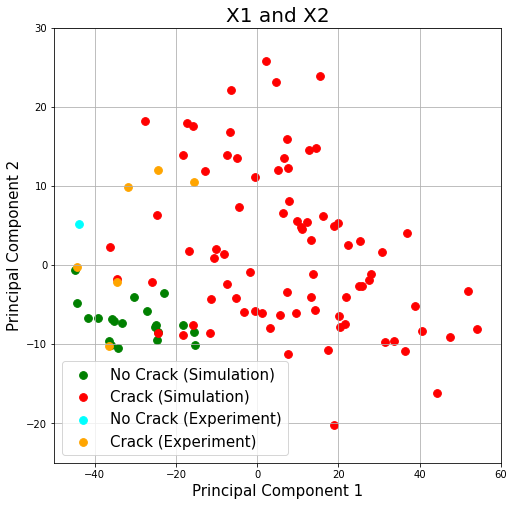

In [36]:
pca = PCA(n_components=2)
principalComponents1 = pca.fit_transform(X1_sim)
principalComponents2 = pca.transform(X1_exp)

principalDf1 = pd.DataFrame(data = principalComponents1, columns = ['principal component 1', 'principal component 2'])
principalDf2 = pd.DataFrame(data = principalComponents2, columns = ['principal component 1', 'principal component 2'])

finalDf1 = pd.concat([principalDf1, y1_sim2], axis = 1)
finalDf2 = pd.concat([principalDf2, y1_exp2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('X1 and X2', fontsize = 20)

targets1 = ['No', 'Yes']
targets2 = ['No', 'Yes']
targets = ['No Crack (Simulation)', 'Crack (Simulation)','No Crack (Experiment)', 'Crack (Experiment)']
colors1 = ['g', 'r']
colors2 = ['cyan','orange']

for target, color in zip(targets1,colors1):
    indicesToKeep1 = finalDf1['Contains_Crack'] == target
    ax.scatter(finalDf1.loc[indicesToKeep1, 'principal component 1']
               , finalDf1.loc[indicesToKeep1, 'principal component 2']
               , c = color
               , s = 60)
for target, color in zip(targets2,colors2):
    indicesToKeep2 = finalDf2['Contains_Crack'] == target
    ax.scatter(finalDf2.loc[indicesToKeep2, 'principal component 1']
               , finalDf2.loc[indicesToKeep2, 'principal component 2']
               , c = color
               , s = 60)
    
ax.legend(targets,fontsize = 15)
ax.grid()
ax.set_xlim(-50,60)
ax.set_ylim(-25,30)
#print(pca.components_*10000)

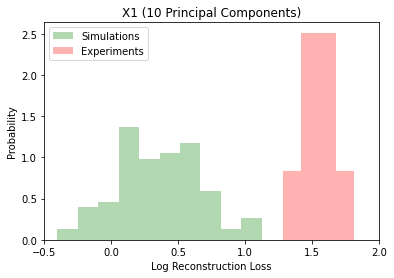

In [66]:
pca = PCA(n_components=10)
principalComponents1 = pca.fit_transform(X1_sim)
principalComponents2 = pca.transform(X1_exp)

y_sim = pca.inverse_transform(principalComponents1)
rec_loss_sim = np.log(np.linalg.norm((X1_sim - y_sim), axis=1))
y_exp = pca.inverse_transform(principalComponents2)
rec_loss_exp = np.log(np.linalg.norm((X1_exp - y_exp), axis=1))

n_bins = 10
plt.figure()
plt.hist(rec_loss_sim,bins=n_bins,density=True,color='green',label='Simulations',alpha=0.3)
plt.hist(rec_loss_exp,bins=n_bins,density=True,color='red',label='Experiments',alpha=0.3)
plt.xlabel('Log Reconstruction Loss')
plt.ylabel('Probability')
plt.xlim(-0.5,2)
plt.title('X1 (10 Principal Components)')
plt.legend()
plt.show()

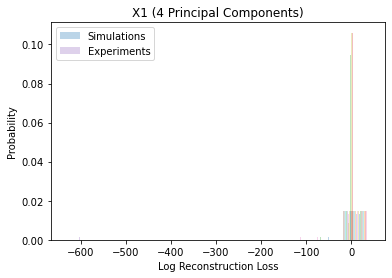

In [39]:
n_bins = 10
plt.figure()
plt.hist(y_sim,bins=n_bins,density=True,label='Simulations',alpha=0.3)
plt.hist(y_exp,bins=n_bins,density=True,label='Experiments',alpha=0.3)
plt.xlabel('Log Reconstruction Loss')
plt.ylabel('Probability')
#plt.xlim(0.5,3.5)
plt.title('X1 (4 Principal Components)')
plt.legend()
plt.show()

(-25.0, 30.0)

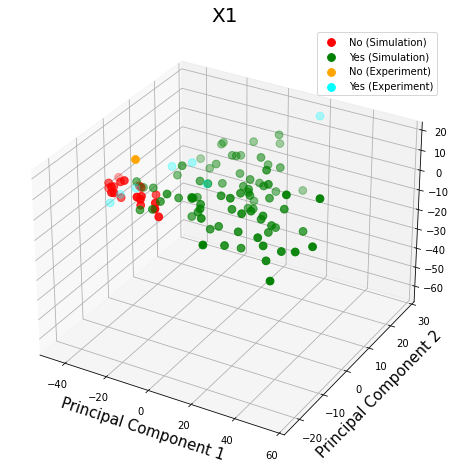

In [29]:
pca = PCA(n_components=3)
principalComponents1 = pca.fit_transform(X1_sim)
principalComponents2 = pca.transform(X1_exp)

principalDf1 = pd.DataFrame(data = principalComponents1, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf2 = pd.DataFrame(data = principalComponents2, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

finalDf1 = pd.concat([principalDf1, y1_sim2], axis = 1)
finalDf2 = pd.concat([principalDf2, y1_exp2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('X1', fontsize = 20)

targets1 = ['No', 'Yes']
targets2 = ['No', 'Yes']
targets = ['No (Simulation)', 'Yes (Simulation)','No (Experiment)', 'Yes (Experiment)']
colors1 = ['r', 'g']
colors2 = ['orange','cyan']

for target, color in zip(targets1,colors1):
    indicesToKeep1 = finalDf1['Contains_Crack'] == target
    ax.scatter(finalDf1.loc[indicesToKeep1, 'principal component 1']
               , finalDf1.loc[indicesToKeep1, 'principal component 2']
               , finalDf1.loc[indicesToKeep1, 'principal component 3']
               , c = color
               , s = 60)
for target, color in zip(targets2,colors2):
    indicesToKeep2 = finalDf2['Contains_Crack'] == target
    ax.scatter(finalDf2.loc[indicesToKeep2, 'principal component 1']
               , finalDf2.loc[indicesToKeep2, 'principal component 2']
               , finalDf2.loc[indicesToKeep2, 'principal component 3']
               , c = color
               , s = 60)
    
ax.legend(targets)
ax.grid()
ax.set_xlim(-50,60)
ax.set_ylim(-25,30)
#print(pca.components_*10000)

[0.04761905 0.06349206 0.0952381  0.07029478 0.         0.
 0.04761905 0.00680272 0.00680272 0.01814059 0.07936508 0.
 0.01587302 0.         0.03174603 0.         0.         0.
 0.04761905 0.         0.03174603 0.         0.01587302 0.
 0.         0.05668934 0.03174603 0.00396825 0.03174603 0.
 0.         0.         0.         0.01587302 0.         0.01587302
 0.03174603 0.         0.         0.06349206 0.         0.04365079
 0.03174603 0.03174603 0.         0.03174603 0.         0.
 0.         0.         0.03174603 0.         0.         0.        ]


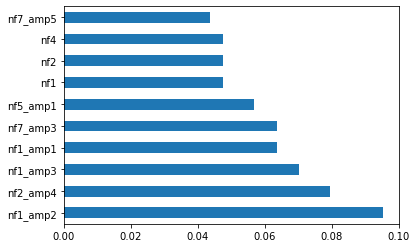

In [6]:
model = RandomForestClassifier()
model.fit(X1_sim,y1_sim)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X1_sim.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

(-25.0, 30.0)

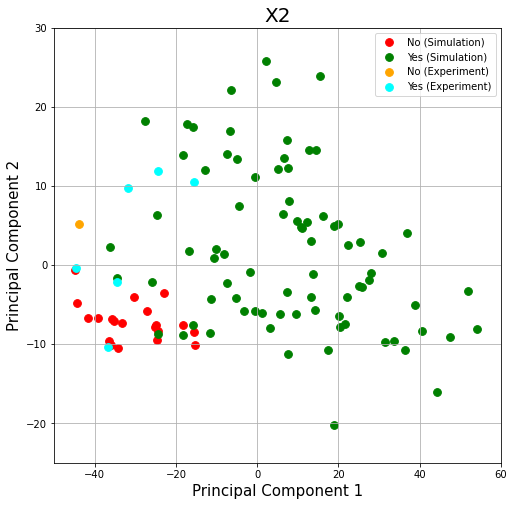

In [23]:
pca = PCA(n_components=2)
principalComponents1 = pca.fit_transform(X2_sim)
principalComponents2 = pca.transform(X2_exp)

principalDf1 = pd.DataFrame(data = principalComponents1, columns = ['principal component 1', 'principal component 2'])
principalDf2 = pd.DataFrame(data = principalComponents2, columns = ['principal component 1', 'principal component 2'])

finalDf1 = pd.concat([principalDf1, y1_sim2], axis = 1)
finalDf2 = pd.concat([principalDf2, y1_exp2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('X2', fontsize = 20)

targets1 = ['No', 'Yes']
targets2 = ['No', 'Yes']
targets = ['No (Simulation)', 'Yes (Simulation)','No (Experiment)', 'Yes (Experiment)']
colors1 = ['r', 'g']
colors2 = ['orange','cyan']

for target, color in zip(targets1,colors1):
    indicesToKeep1 = finalDf1['Contains_Crack'] == target
    ax.scatter(finalDf1.loc[indicesToKeep1, 'principal component 1']
               , finalDf1.loc[indicesToKeep1, 'principal component 2']
               , c = color
               , s = 60)
for target, color in zip(targets2,colors2):
    indicesToKeep2 = finalDf2['Contains_Crack'] == target
    ax.scatter(finalDf2.loc[indicesToKeep2, 'principal component 1']
               , finalDf2.loc[indicesToKeep2, 'principal component 2']
               , c = color
               , s = 60)
    
ax.legend(targets)
ax.grid()
ax.set_xlim(-50,60)
ax.set_ylim(-25,30)
#print(pca.components_*10000)

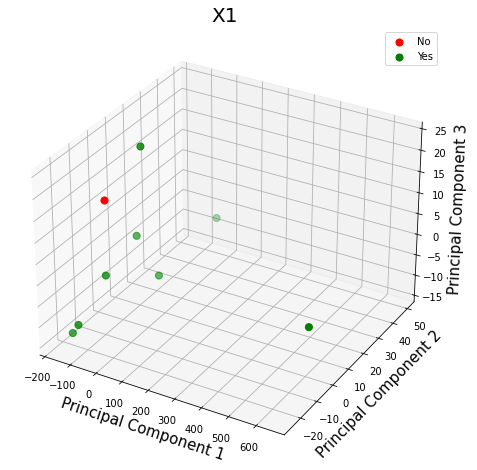

In [8]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X2_sim)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

finalDf = pd.concat([principalDf, y1_sim2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('X1', fontsize = 20)

targets = ['No', 'Yes']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Contains_Crack'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#print(pca.components_*10000)

[0.12096774 0.20967742 0.08189516 0.27294355 0.01598502 0.01612903
 0.11995968 0.15322581 0.00921659]


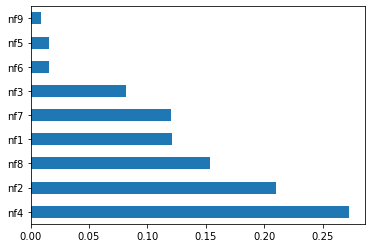

In [9]:
model = RandomForestClassifier()
model.fit(X2_sim,y1_sim)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X2_sim.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

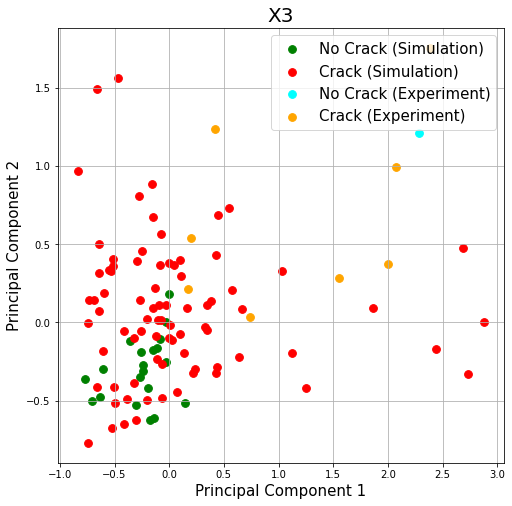

In [37]:
pca = PCA(n_components=2)
principalComponents1 = pca.fit_transform(X3_sim)
principalComponents2 = pca.transform(X3_exp)

principalDf1 = pd.DataFrame(data = principalComponents1, columns = ['principal component 1', 'principal component 2'])
principalDf2 = pd.DataFrame(data = principalComponents2, columns = ['principal component 1', 'principal component 2'])

finalDf1 = pd.concat([principalDf1, y1_sim2], axis = 1)
finalDf2 = pd.concat([principalDf2, y1_exp2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('X3', fontsize = 20)

targets1 = ['No', 'Yes']
targets2 = ['No', 'Yes']
targets = ['No Crack (Simulation)', 'Crack (Simulation)','No Crack (Experiment)', 'Crack (Experiment)']
colors1 = ['g', 'r']
colors2 = ['cyan','orange']

for target, color in zip(targets1,colors1):
    indicesToKeep1 = finalDf1['Contains_Crack'] == target
    ax.scatter(finalDf1.loc[indicesToKeep1, 'principal component 1']
               , finalDf1.loc[indicesToKeep1, 'principal component 2']
               , c = color
               , s = 60)
for target, color in zip(targets2,colors2):
    indicesToKeep2 = finalDf2['Contains_Crack'] == target
    ax.scatter(finalDf2.loc[indicesToKeep2, 'principal component 1']
               , finalDf2.loc[indicesToKeep2, 'principal component 2']
               , c = color
               , s = 60)
    
ax.legend(targets,fontsize = 15)
ax.grid()
#ax.set_xlim(-50,60)
#ax.set_ylim(-25,30)
#print(pca.components_*10000)

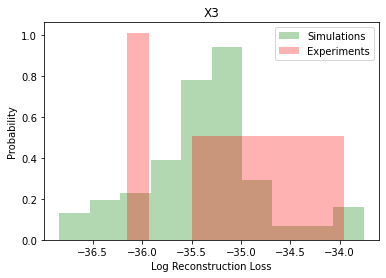

In [58]:
pca = PCA(n_components=5)
principalComponents1 = pca.fit_transform(X3_sim)
principalComponents2 = pca.transform(X3_exp)

y_sim = pca.inverse_transform(principalComponents1)
rec_loss_sim = np.log(np.linalg.norm((X3_sim - y_sim), axis=1))
y_exp = pca.inverse_transform(principalComponents2)
rec_loss_exp = np.log(np.linalg.norm((X3_exp - y_exp), axis=1))

n_bins = 10
plt.figure()
plt.hist(rec_loss_sim,bins=n_bins,density=True,color='green',label='Simulations',alpha=0.3)
plt.hist(rec_loss_exp,bins=n_bins,density=True,color='red',label='Experiments',alpha=0.3)
plt.xlabel('Log Reconstruction Loss')
plt.ylabel('Probability')
#plt.ylim(0,1)
plt.title('X3')
plt.legend()
plt.show()

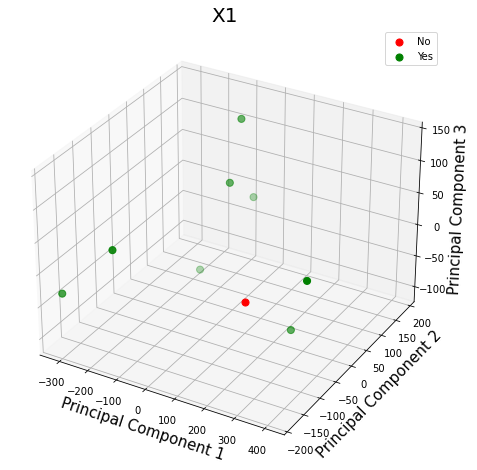

In [11]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X3_sim)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

finalDf = pd.concat([principalDf, y1_sim2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('X1', fontsize = 20)

targets = ['No', 'Yes']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Contains_Crack'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#print(pca.components_*10000)

[0.26008598 0.13632606 0.14885913 0.20287698 0.25185185]


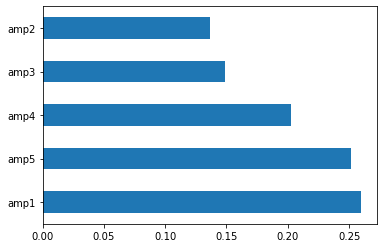

In [12]:
model = RandomForestClassifier()
model.fit(X3_sim,y1_sim)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X3_sim.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Situation 2

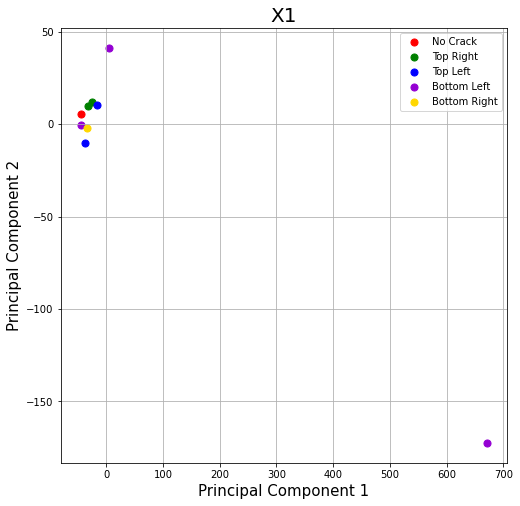

In [33]:
pca = PCA(n_components=2)
pca.fit(X1_sim)
principalComponents = pca.transform(X1_exp)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y2_exp2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('X1', fontsize = 20)

targets = ['No Crack', 'Top Right', 'Top Left', 'Bottom Left', 'Bottom Right']
colors = ['r', 'g', 'b', 'darkviolet', 'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Position_of_Crack'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

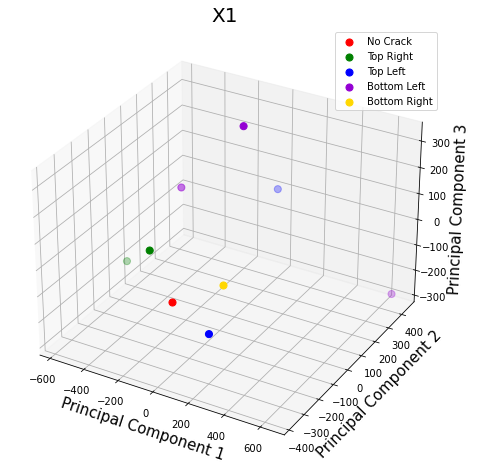

In [14]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X1_sim)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

finalDf = pd.concat([principalDf, y2_sim2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('X1', fontsize = 20)

targets = ['No Crack', 'Top Right', 'Top Left', 'Bottom Left', 'Bottom Right']
colors = ['r', 'g', 'b', 'darkviolet', 'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Position_of_Crack'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

[0.0133594  0.01       0.02658298 0.03920147 0.0107448  0.00695545
 0.03098575 0.01585873 0.01259688 0.01477357 0.01140092 0.02491452
 0.02625493 0.01856894 0.02206745 0.0242529  0.07047438 0.02910734
 0.01662385 0.01361931 0.01688072 0.01490968 0.00897022 0.01439217
 0.00155172 0.00431034 0.0163921  0.01720891 0.02009656 0.03535231
 0.02284305 0.02059892 0.02967853 0.01707371 0.01140775 0.03750626
 0.00942714 0.0041129  0.02011841 0.03128109 0.01820866 0.0069023
 0.00564409 0.01374713 0.01432647 0.03019007 0.01044039 0.00633127
 0.         0.02372793 0.02143129 0.01977707 0.02073978 0.01607749]


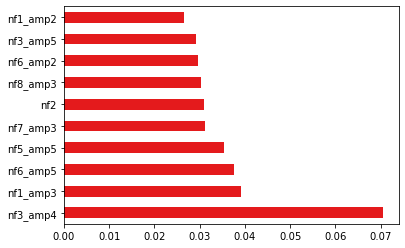

In [15]:
model = RandomForestClassifier()
model.fit(X1_sim,y2_sim)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X1_sim.columns)
feat_importances.nlargest(10).plot(kind='barh', cmap='Set1')
plt.show()

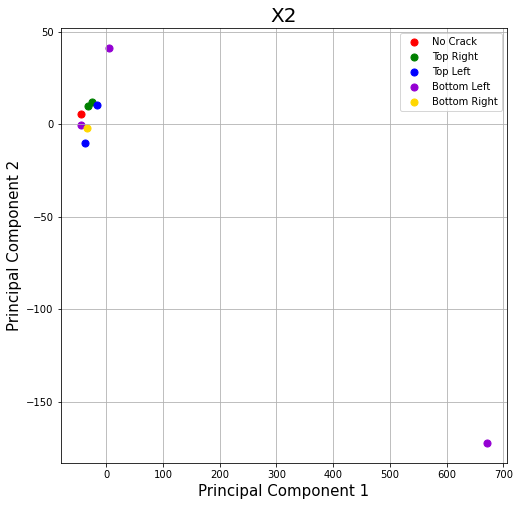

In [36]:
pca = PCA(n_components=2)
pca.fit(X2_sim)
principalComponents = pca.transform(X2_exp)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y2_exp2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('X2', fontsize = 20)

targets = ['No Crack', 'Top Right', 'Top Left', 'Bottom Left', 'Bottom Right']
colors = ['r', 'g', 'b', 'darkviolet', 'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Position_of_Crack'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

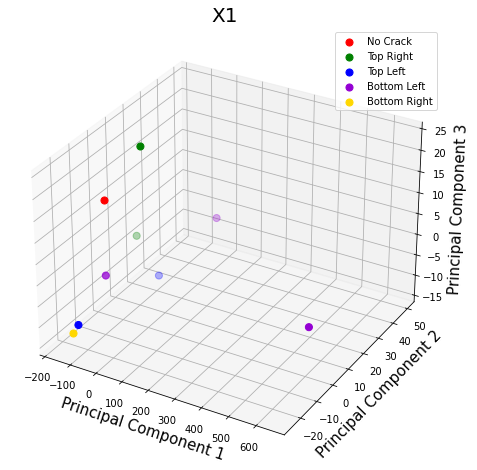

In [17]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X2_sim)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

finalDf = pd.concat([principalDf, y2_sim2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('X2', fontsize = 20)

targets = ['No Crack', 'Top Right', 'Top Left', 'Bottom Left', 'Bottom Right']
colors = ['r', 'g', 'b', 'darkviolet', 'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Position_of_Crack'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

[0.09100512 0.12072604 0.11779753 0.1217406  0.05644155 0.12058652
 0.10435293 0.14274084 0.12460888]


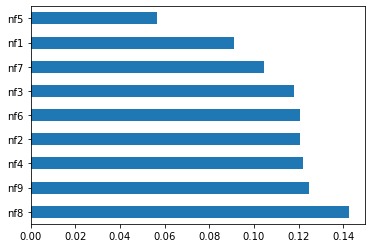

In [18]:
model = RandomForestClassifier()
model.fit(X2_sim,y2_sim)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X2_sim.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

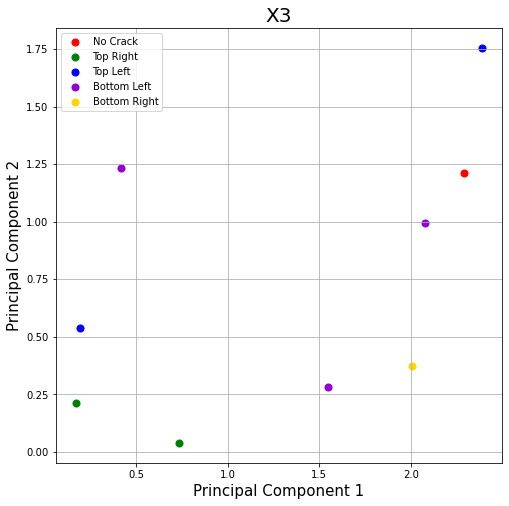

In [35]:
pca = PCA(n_components=2)
pca.fit(X3_sim)
principalComponents = pca.transform(X3_exp)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y2_exp2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('X3', fontsize = 20)

targets = ['No Crack', 'Top Right', 'Top Left', 'Bottom Left', 'Bottom Right']
colors = ['r', 'g', 'b', 'darkviolet', 'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Position_of_Crack'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

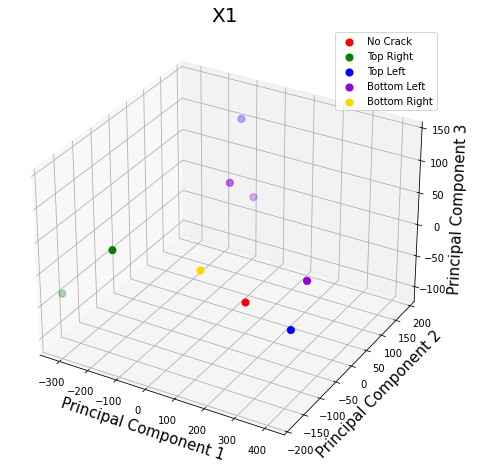

In [20]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X3_sim)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

finalDf = pd.concat([principalDf, y2_sim2], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('X1', fontsize = 20)

targets = ['No Crack', 'Top Right', 'Top Left', 'Bottom Left', 'Bottom Right']
colors = ['r', 'g', 'b', 'darkviolet', 'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Position_of_Crack'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

[0.17619994 0.28389843 0.24371284 0.16292913 0.13325967]


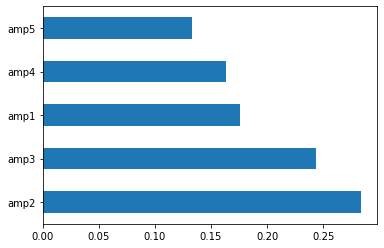

In [21]:
model = RandomForestClassifier()
model.fit(X3_sim,y2_sim)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X3_sim.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()